# Training an image classifier
#### We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Loading and normalizing CIFAR10

In [16]:
import torch 
import torchvision 
import torchvision.transforms as transforms

#o/p of tov images are pil images of range [0,1]-->> convert to tensors of normalized range [0,1]

transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


truck  deer   dog  ship


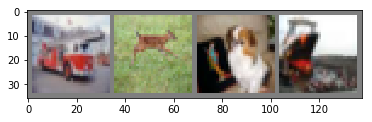

In [19]:

import matplotlib.pyplot as plt
import numpy as np 

# visualize an image 

def imshow(img):
    img = img / 2 + 0.5  # un-normalize 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    
# random training data 
dataIter = iter(trainloader)
images, labels = dataIter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()    

### 2. Define a Convolution Neural Network  
#### 3 channel input -> 6 o/p , 5X5 conv kernel

In [27]:
import torch.nn as nn 
import torch.nn.functional as F 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [28]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 3. Define a Loss function and optimizer
#### Let’s use a Classification Cross-Entropy loss and SGD with momentum.



In [29]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum = 0.9)

### 4. Train the Network 
#### loop over our data iterator, and feed the inputs to the network and optimize.

In [31]:
for epoch in range(3): # loop over 3 times 
    running_loss = 0.0 
    for i, data in enumerate(trainloader, 0):
        
        # get inputs
        inputs, labels = data
        
        # zero the gradients 
        optimizer.zero_grad()
        
        # forward 
        outputs = net(inputs)
        # backward 
        loss = criterion(outputs, labels)
        loss.backward()
        # update weight
        optimizer.step()
        
        # print stats 
        running_loss += loss.item()
        
        # print every 2000 mini batches 
        if i%2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i+ 1, running_loss/2000))
            running_loss = 0.0
print("Done Training" )

[1,  2000] loss: 1.931
[1,  4000] loss: 1.720
[1,  6000] loss: 1.632
[1,  8000] loss: 1.555
[1, 10000] loss: 1.497
[1, 12000] loss: 1.446
[2,  2000] loss: 1.382
[2,  4000] loss: 1.361
[2,  6000] loss: 1.345
[2,  8000] loss: 1.318
[2, 10000] loss: 1.305
[2, 12000] loss: 1.282
[3,  2000] loss: 1.225
[3,  4000] loss: 1.202
[3,  6000] loss: 1.192
[3,  8000] loss: 1.190
[3, 10000] loss: 1.184
[3, 12000] loss: 1.165
Done Training


### 5. Test the network on the test data


GroundTruth:    cat  ship  ship plane


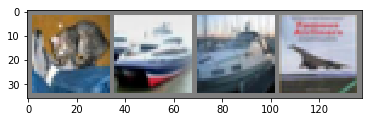

In [32]:
dataIter = iter(testloader)
images, labels = dataIter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [34]:
test_outputs = net(images)

##### The outputs are energies for the 10 classes. Higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [35]:
_, predicted = torch.max(test_outputs, 1)

print('Predicted', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted   cat   car   car plane


In [36]:
# Test for entire test dataset 

correct = 0 
total = 0 

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total+= labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %
